In [3]:
import zen
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as progress

#### Compare the speed of the Katz-eigen plot method of community detection with that of Louvain community detection, using the 328-node Amazon product network.

In [4]:
G = zen.io.gml.read('amazon_product.gml')

In [4]:
def katz(G,tol=0.01,max_iter=1000,alpha=0.001,beta=1):
    iteration = 0
    centrality = np.zeros(G.num_nodes)
    while iteration < max_iter:
        iteration += 1          # increment iteration count
        centrality_old = centrality.copy()

        for node in G.nodes_():
            Ax = 0
            for neighbor in G.neighbors_(node):
                weight = G.weight_(G.edge_idx_(neighbor,node))
                Ax += np.multiply(centrality[neighbor],weight)

                #Ax += centrality[neighbor]      #exclude weight due to overflow in multiplication

            centrality[node] = np.multiply(alpha,Ax)+beta

        if np.sum(np.abs(np.subtract(centrality,centrality_old))) < tol:
            return centrality

In [1]:
def modular_graph(Size1, Size2, edges1, edges2, common, katz_alpha=0.001):
    g1 = zen.generating.barabasi_albert(Size1,edges1)
    avgDeg1 = (2.0 * g1.num_edges)/g1.num_nodes
    lcc1 = np.mean(zen.algorithms.clustering.lcc_(g1))
    
    g2 = zen.generating.barabasi_albert(Size2,edges2)
    avgDeg2 = (2.0 * g2.num_edges)/g2.num_nodes
    lcc2 = np.mean(zen.algorithms.clustering.lcc_(g2))
    
    Size = Size1 + Size2
    G = zen.Graph()
    for i in range(Size):
        G.add_node(i)

    for edge in g1.edges_iter():
        u = edge[0]
        v = edge[1]
        G.add_edge(u,v)

    for edge in g2.edges_iter():
        u = edge[0]+Size1
        v = edge[1]+Size1
        G.add_edge(u,v)

    # Select random pairs of nodes to connect the subgraphs
    join_nodes = np.empty((common,2),dtype=np.int64)
    nodes1 = np.random.randint(0,Size1,size=common)
    nodes2 = np.random.randint(Size1,Size,size=common)
    join_nodes[:,0] = nodes1
    join_nodes[:,1] = nodes2

    for edge in join_nodes:
        if not G.has_edge(edge[0],edge[1]):
            G.add_edge(edge[0],edge[1])
    
    return G

In [5]:
def modularity(G,classDict,classList):
    Q = zen.algorithms.modularity(G,classDict)
    # Maximum Modularity
    count=0.0
    for e in G.edges():
        n1 = G.node_idx(e[0])
        n2 = G.node_idx(e[1])
        if classList[n1] == classList[n2]:
            count += 1
    same = count / G.num_edges
    rand = same - Q
    qmax = 1 - rand
    return Q, qmax

In [1]:
from zen.algorithms.community import louvain
from sklearn.cluster import AgglomerativeClustering as AC

#### See if we can improve the modularity through better groupings of nodes

In [112]:
cset = louvain(G)

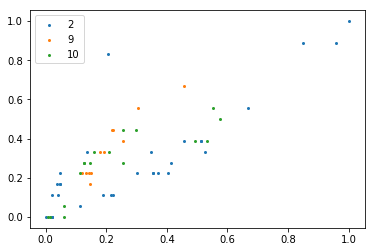

In [121]:
for i,community in enumerate(cset.communities()):
    if i+1 in [2,10,9]:
        nodes = community.nodes_()
        plt.scatter(evc[nodes],kc[nodes],s=8,label=(i+1))
plt.legend()

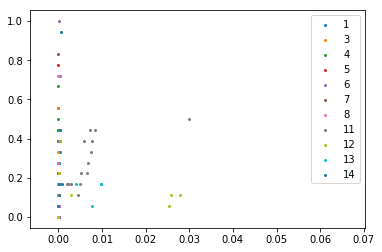

In [119]:
for i,community in enumerate(cset.communities()):
    if i+1 not in [2,10,9]:
        nodes = community.nodes_()
        plt.scatter(evc[nodes],kc[nodes],s=8,label=(i+1))
plt.legend()

In [131]:
comm1 = []
comm2 = []

for i,community in enumerate(cset.communities()):
    nodes = list(community.nodes_())
    if i+1 in [2,10,9]:
        comm1.extend(nodes)
    else:
        comm2.extend(nodes)
ClassDict = {0:[G.node_object(x) for x in comm1], 1:[G.node_object(y) for y in comm2]}
ClassList = np.zeros(G.num_nodes)
ClassList[comm2] = 1

q,qmax = modularity(G,ClassDict,ClassList)
print 'Normalized Q: %.3f'%(q/qmax)

Normalized Q: 0.982


## Test on synthetic graphs

In [51]:
G_synth = modular_graph(500,500,15,20,100,katz_alpha=1e-4)
print "Nodes: %d"%G_synth.num_nodes
print "Edges: %d"%G_synth.num_edges

Nodes: 1000
Edges: 16975


#### Here, KE and Louvain both find 2 communities with the same modularity, suggesting their communities are identical. Verifying below.

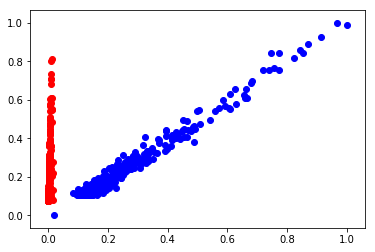

In [55]:
import matplotlib.pyplot as plt
evc = zen.algorithms.eigenvector_centrality_(G_synth)
kc = katz(G_synth,alpha=1e-4)
evc = evc - np.min(evc)
evc = evc / np.max(evc)
kc  = kc - np.min(kc)
kc = kc / np.max(kc)

# make feature set
X = np.empty((len(evc),2))
X[:,0] = evc
X[:,1] = kc

#[0,0]s will not be compatible with cosine similarity since they have no magnitude. Add small amount.
s = pd.Series(np.array(np.where(X==0))[0])
X[s[s.duplicated()].values,:] = [1e-12,1e-12]

# detect communities
clusters = AC(n_clusters=2,affinity='cosine',linkage='complete').fit(X)
labels = clusters.labels_
plt.scatter(evc[np.where(labels==0)[0]],kc[np.where(labels==0)[0]],color='b')
plt.scatter(evc[np.where(labels==1)[0]],kc[np.where(labels==1)[0]],color='r')

In [66]:
cset = louvain(G_synth)

In [67]:
louvain_com1 = cset.communities()[0].nodes_()
louvain_com2 = cset.communities()[1].nodes_()

ke_com1 = np.arange(1000)[np.where(labels==1)[0]]
ke_com2 = np.arange(1000)[np.where(labels==0)[0]]

print (louvain_com1 == ke_com1).all()
print (louvain_com2 == ke_com2).all()

True
True


#### It is verified that both KE and Louvain found the same communities. Now let's look at a scenario where agglomerative clustering fails.

In [70]:
G_synth = modular_graph(500,500,2,8,100,katz_alpha=1e-4)
print "Nodes: %d"%G_synth.num_nodes
print "Edges: %d"%G_synth.num_edges

Nodes: 1000
Edges: 5032


#### The KE communities had poor modularity; much worse than those found by Louvain. This is because the agglomerative clustering algorithm failed to separate the clear clusters.

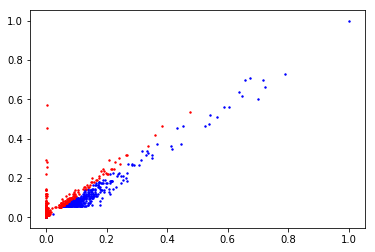

In [75]:
evc = zen.algorithms.eigenvector_centrality_(G_synth)
kc = katz(G_synth,alpha=1e-4)
evc = evc - np.min(evc)
evc = evc / np.max(evc)
kc  = kc - np.min(kc)
kc = kc / np.max(kc)

# make feature set
X = np.empty((len(evc),2))
X[:,0] = evc
X[:,1] = kc

#[0,0]s will not be compatible with cosine similarity since they have no magnitude. Add small amount.
s = pd.Series(np.array(np.where(X==0))[0])
X[s[s.duplicated()].values,:] = [1e-12,1e-12]

# detect communities
clusters = AC(n_clusters=2,affinity='cosine',linkage='complete').fit(X)
labels = clusters.labels_
plt.scatter(evc[np.where(labels==0)[0]],kc[np.where(labels==0)[0]],color='b',s=2)
plt.scatter(evc[np.where(labels==1)[0]],kc[np.where(labels==1)[0]],color='r',s=2)

#### There are many red nodes that should be colored green. It is noteworthy though that the Louvain communities are largely divided between the two obvious clusters

In [78]:
cset = louvain(G_synth)

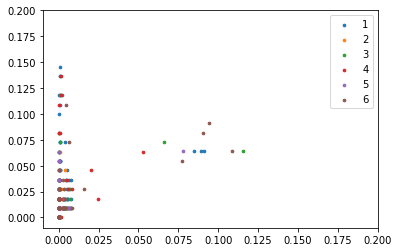

In [101]:
for i,com in enumerate(cset.communities()):
    if i+1 in [1,3,4,5,6,2]:
        nodes = com.nodes_()
        plt.scatter(evc[nodes],kc[nodes],s=7,label='%d'%(i+1))

plt.ylim([-0.01,0.2])
plt.xlim([-0.01,0.2])
plt.legend()

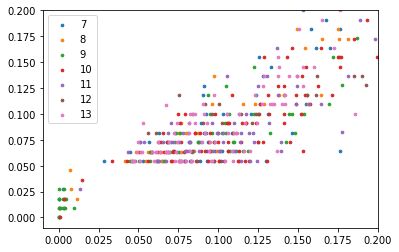

In [99]:
for i,com in enumerate(cset.communities()):
    if i+1 not in [1,3,4,5,6,2]:
        nodes = com.nodes_()
        plt.scatter(evc[nodes],kc[nodes],s=7,label='%d'%(i+1))

plt.ylim([-0.01,0.2])
plt.xlim([-0.01,0.2])
plt.legend()

#### Communities 1-6 are largely in the verticle cluster, and 7-13 are in the diagonal cluster. Louvain community detection is essentially classifying the communities in the same manner as the KE method, but with longer runtime and more sensitivity to noise. It we look the modularity resulting from choosing communites by membership in Louvain 1-6 and Louvain 7-13 (in this case it's basically nodes with eigenvector centrality less than/greater than 0.025) we see ...